In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import DB_library as DBL
import numpy as np
import os

sns.set_theme()

In [2]:
path_to_XDATCAR = '../../ICMAB/Data/Li-based/Li10GeS2P12/AIMD/stoichiometric/650K'

The ionic conductivity ($\sigma$) computes from [@tateyama]:

\begin{equation}
    \begin{gathered}
        \sigma = \lim_{\Delta t \to \infty} \frac{e^2}{2 n_d V k_B T} \left[ \sum_i z_i^2 \langle \left[ \mathbf{r}_i(t_0 + \Delta t) - \mathbf{r}_i(t_0) \right]^2 \rangle_{t_0} + \right. \\
        \left. + \sum_{i, j \neq i} z_i z_j \langle \left[ \mathbf{r}_i(t_0 + \Delta t) - \mathbf{r}_i(t_0) \right] \cdot \left[ \mathbf{r}_j(t_0 + \Delta t) - \mathbf{r}_j(t_0) \right] \rangle_{t_0} \right]
    \end{gathered}
\end{equation}

where $e$, $V$, $k_B$, and $T$ are the elementary charge, system volume, Boltzmann constant, and temperature of the MD simulation, respectively, $z_i$ charge and $\mathbf{r}_i = x_{1, i} \hat{i} + x_{2, i} \hat{j} + x_{3, i} \hat{k}$ cartesian position of particle $i$, and $n_d$ is the number of spatial dimensions of $\mathbf{r}_i$, $\Delta t$ is the time window and $t_0$ the temporal offset of $\Delta t$. Thus, for those simulations in which one only species diffusses, the ionic diffusion coefficient reads: 

\begin{equation}
    \begin{gathered}
        D = \lim_{\Delta t \to \infty} \frac{1}{6 \Delta t} \left[ \sum_i \langle \left[ \mathbf{r}_i(t_0 + \Delta t) - \mathbf{r}_i(t_0) \right]^2 \rangle_{t_0} + \right. \\
        \left. + \sum_{i, j \neq i} \langle \left[ \mathbf{r}_i(t_0 + \Delta t) - \mathbf{r}_i(t_0) \right] \cdot \left[ \mathbf{r}_j(t_0 + \Delta t) - \mathbf{r}_j(t_0) \right] \rangle_{t_0} \right] = \\
        = \lim_{\Delta t \to \infty} \frac{1}{6 \Delta t} \left[ \text{MSD}_{self} (\Delta t) + \text{MSD}_{distinct} (\Delta t) \right]
    \end{gathered}
\end{equation}

As a result, all these displacements can be computed just once, and stored in a three-dimensional tensor, what allows simple vectorization and runs much faster in libraries such as Numpy compared to traditional loops. Then, for a simulation with $n_t$ time steps, and $n_p$ number of atoms for the diffusive species, we only need to compute:

\begin{equation}
    \Delta x (\Delta t, i, d, t_0) = x_{d, i} (t_0 + \Delta t) - x_{d, i} (t_0)
\end{equation}

being $\Delta x(\Delta t, i, d, t_0)$ a four-dimensional tensor of shape $n_t \times n_t \times n_p \times n_d$ storing all mean displacements of temporal length $\Delta t$ for particle $p_i$ in catersian dimension $d$. This leads to:

\begin{equation}
    \text{MSD}_{self} (\Delta t) = \frac{1}{n_p} \sum_{i = 1}^{n_p} \langle \sum_{d} \Delta x (\Delta t, i, d, t_0) \cdot \Delta x (\Delta t, i, d, t_0) \rangle_{t_0}
\end{equation}

\begin{equation}
    \text{MSD}_{distinct} (\Delta t) = \frac{2}{n_p (n_p-1)} \sum_{i = 1}^{n_p} \sum_{j = i+1}^{n_p} \langle \sum_{d} \Delta x (\Delta t, i, d, t_0) \cdot \Delta x (\Delta t, j, d, t_0) \rangle_{t_0}
\end{equation}

Note that we keep $D_{self}$ and $D_{distinct}$ separate as this allows analising easily the contribution of crossed terms to $D$ without adding any code complication.

This implementation scales quadratic with the lenght of the simulation and linearly with the number of diffusive particles in terms of memory resources.

### Extract data from INCAR file at path_to_XDATCAR

In [3]:
def read_INCAR(path_to_simulation):
    """Reads VASP INCAR files. It is always expected to find these parameters.
    Read VASP INCAR Settings

    Args:
        path_to_simulation (str): Path to the simulation directory.

    Returns:
        tuple: A tuple containing delta_t and n_steps.
    """
    
    # Predefining the variable, so later we check if they were found
    
    delta_t = None
    n_steps = None
    
    # Loading the INCAR file
    
    if not os.path.exists(f'{path_to_simulation}/INCAR'):
        exit('INCAR file is not available.')
    
    with open(f'{path_to_simulation}/INCAR', 'r') as INCAR_file:
        INCAR_lines = INCAR_file.readlines()
    
    # Looking for delta_t and n_steps
    
    for line in INCAR_lines:
        split_line = line.split('=')
        if len(split_line) > 1:  # Skipping empty lines
            label = split_line[0].split()[0]
            value = split_line[1].split()[0]
            
            if   label == 'POTIM':  delta_t = float(value)
            elif label == 'NBLOCK': n_steps = float(value)
    
    # Checking if they were found
    
    if (delta_t is None) or (n_steps is None):
        exit('POTIM or NBLOCK are not correctly defined in the INCAR file.')
    return delta_t, n_steps

INCAR_delta_t, INCAR_n_steps = read_INCAR(path_to_XDATCAR)
INCAR_delta_t, INCAR_n_steps

(1.5, 10.0)

### Extract data from XDATCAR file at path_to_XDATCAR

In [4]:
# Import the XDATCAR file
XDATCAR_lines = [line for line in open(f'{path_to_XDATCAR}/XDATCAR') if line.strip()]

# Extract initial XDATCAR data
compound = XDATCAR_lines[0][:-1]
scale    = float(XDATCAR_lines[1])

lattice_vectors = np.array([line.split() for line in XDATCAR_lines[2:5]], dtype=float)
lattice_vectors *= scale  # Use scaling

composition   = XDATCAR_lines[5].split()
concentration = np.array(XDATCAR_lines[6].split(), dtype=int)

n_atoms = np.sum(concentration)  # Number of particles within the simulation box

print_name = ' '.join(composition)
print(f'Compound: {compound}')
print(f'Composition: {print_name}')
print(f'Concentration: {concentration}')

# Shape the configurations data into the positions attribute
direct_coordinates = np.array([line.split() for line in XDATCAR_lines[8:] if not line.split()[0][0].isalpha()], dtype=float)

direct_coordinates = direct_coordinates.ravel().reshape((-1, n_atoms, 3))  # (n_conf, n_atoms, 3) tensor
n_conf = direct_coordinates.shape[0]  # Number of configurations or simulation steps

print(f'Number of configurations: {n_conf}')

Compound: Li10GeS2P12
Composition: Li Ge P S
Concentration: [80  8 16 96]
Number of configurations: 9966


### Identify diffusive particles

In [5]:
diffusive_particle = 'Li'

for i in range(n_atoms):
    if composition[i] == diffusive_particle:
        diffusive_idx = i
        break

concentration_cumsum = np.insert(np.cumsum(concentration), 0, 0)

# Exact indexes of the diffive particles
diffusive_indexes = np.arange(concentration_cumsum[diffusive_idx],
                              concentration_cumsum[diffusive_idx+1],
                             dtype=int)

# Index where the diffive particles start
diffusive_indexes_start = diffusive_indexes[0]

# Number of diffive particles
n_diff_atoms = len(diffusive_indexes)

diffusive_indexes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])

### Revert periodic boundary conditions and pass to cartesian coordinates

In [6]:
# Get the variation in positions
dpos = np.diff(direct_coordinates, axis=0)

# Revert periodic boundary condition
dpos[dpos > 0.5]  -= 1.0
dpos[dpos < -0.5] += 1.0

# Pass to cartesian
for i in range(n_conf-1):
    dpos[i] = np.dot(dpos[i], lattice_vectors)

# Copy direct to cartesian and pass first frame (configuration)
cartesian_coordinates    = direct_coordinates.copy()
cartesian_coordinates[0] = np.dot(cartesian_coordinates[0], lattice_vectors)

# Expand dimensions and sum every dpos
expanded_dimensions   = np.expand_dims(cartesian_coordinates[0], 0)
cartesian_coordinates = np.concatenate([expanded_dimensions, dpos], axis=0)
cartesian_coordinates = np.cumsum(cartesian_coordinates, axis=0)

In [9]:
# Consider only diffusive atoms
diff_cartesian_coordinates = cartesian_coordinates[:, diffusive_indexes]

### Generate tensor

In [13]:
n_conf = 500

In [14]:
differences_tensor_mean = np.ones((n_conf, n_conf, n_diff_atoms, 3)) * np.NaN
#differences_tensor_std  = np.ones((n_conf, n_conf, n_diff_atoms, 3)) * np.NaN

# delta_t = 0 gives 0 by definition
differences_tensor_mean[0] = 0

In [18]:
differences_tensor_mean = np.ones((n_conf, n_conf, n_diff_atoms, 3)) * np.NaN

differences_tensor_mean[0] = 0

# We vectorize in terms of n_atoms (only possibility here)
for delta_t in np.arange(1, n_conf):
    # Number of windows which are used for screening distances
    n_windows = n_conf - delta_t
    
    # Generate mean over windows
    for t_0 in range(n_windows):
        # Distance between two configurations of a same particle
        # td (atom_i, dim_i) = cc (t_0 + delta_t, atom_i, dim_k) - cc (t_0, atom_i, dim_k)
        temporal_dist = diff_cartesian_coordinates[t_0 + delta_t] - diff_cartesian_coordinates[t_0]

        # Add to temporal variable
        differences_tensor_mean[delta_t, t_0] = temporal_dist

### Generate MSD

#### Self

In [69]:
# Scalar product between self particles
self_scalar_product = differences_tensor_mean * differences_tensor_mean
self_scalar_product = np.sum(self_distances, axis=-1)

# Apply average for particles
particles_avg = np.nanmean(self_scalar_product, axis=-1)  # Raises warning due to NaNs in some positions

# Apply average for windows
MSD_self = np.nanmean(particles_avg, axis=-1)

/var/folders/m5/whlk89kx5x17v9g6d328s3f40000gn/T/ipykernel_33570/2989324233.py:6: RuntimeWarning: Mean of empty slice
  particles_avg = np.nanmean(self_scalar_product, axis=-1)


#### Distinct

In [84]:
n_distinct = (n_diff_atoms * (n_diff_atoms - 1)) / 2

particles_sum = np.zeros((n_conf, n_conf))
for idx_i in np.arange(n_diff_atoms):
    # All remaining indexes
    idx_j = np.arange(idx_i+1, n_diff_atoms)
    
    # Extract data
    diff_i = differences_tensor_mean[:, :, np.newaxis, idx_i]  # np.newaxis to allow dot product
    diff_j = differences_tensor_mean[:, :, idx_j]
    
    # Scalar product between distinct particles
    distinct_scalar_product = diff_i * diff_j
    distinct_scalar_product = np.sum(distinct_scalar_product, axis=-1)
    
    # Apply sum for particles
    particles_sum += np.sum(distinct_scalar_product, axis=-1)

# Apply average for particles
particles_avg = particles_sum / n_distinct

# Apply average for windows
MSD_distinct = np.nanmean(particles_avg, axis=-1)

#### Full

In [85]:
# Add both contributions
MSD_full = MSD_self + MSD_distinct

# Define the array of time simulation in pico-seconds
delta_t_array = np.arange(n_conf) * (INCAR_n_steps * INCAR_delta_t * 1e-3)

### Compute diffusion coefficient

In [89]:
initial_point = 0.1
ending_point  = 0.7
x_fit = delta_t_array

if initial_point is None: initial_point = int(0.1 * n_conf)
else:                     initial_point = int(initial_point * n_conf)

if ending_point is None: ending_point = int(0.9 * n_conf)
else:                    ending_point = int(ending_point * n_conf)

y_fit    = MSD_self
yerr_fit = None  #yerr_fit = MSD_self_std
_beta_ = DBL.weighted_regression(x_fit[initial_point:ending_point],
                                 y_fit[initial_point:ending_point],
                                 DBL.linear_function,
                                 yerr=yerr_fit).beta
coef_D_self = _beta_[1]

y_fit    = MSD_full
yerr_fit = None  #yerr_fit = MSD_full_std
_beta_ = DBL.weighted_regression(x_fit[initial_point:ending_point],
                                 y_fit[initial_point:ending_point],
                                 DBL.linear_function,
                                 yerr=yerr_fit).beta
coef_D_full = _beta_[1]

coef_D_self, coef_D_full

(0.14230815599743257, 0.1580709788578664)

### Plot MSD

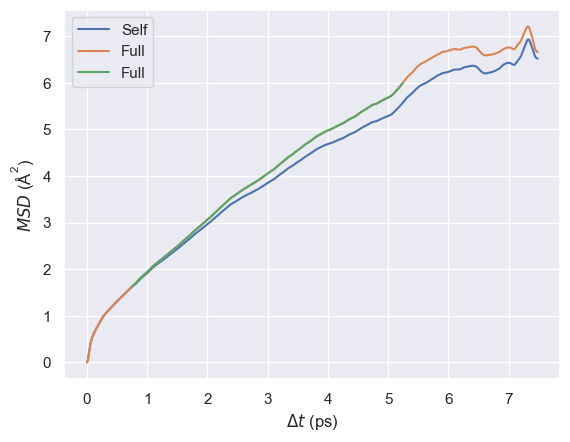

In [90]:
plt.plot(delta_t_array,
         MSD_self,
         label='Self')
plt.plot(delta_t_array,
         MSD_full,
         label='Full')

plt.plot(delta_t_array[initial_point:ending_point],
         MSD_full[initial_point:ending_point],
         label='Full')

plt.xlabel(r'$\Delta t$ (ps)')
plt.ylabel(r'$MSD$ ($\mathregular{Å^2}$)')
plt.legend(loc='best')
plt.show()